In [265]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import Normalize
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc

import warnings
warnings.filterwarnings('ignore')

from ipynb.fs.full.utils import integrated_gradients

In [289]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
test_dataset = torchvision.datasets.FashionMNIST(root='./datasets', train=False, transform=transformer, download=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, pin_memory=True)

In [291]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = torch.nn.Conv2d(1, 6, 5)
        self.pool_1 = torch.nn.MaxPool2d(2, 2)
        self.relu_1 = torch.nn.ReLU()
        self.conv_2 = torch.nn.Conv2d(6, 16, 5)
        self.pool_2 = torch.nn.MaxPool2d(2, 2)
        self.relu_2 = torch.nn.ReLU()
        self.fc_1 = torch.nn.Linear(256, 120)
        self.relu_3 = torch.nn.ReLU()
        self.fc_2 = torch.nn.Linear(120, 84)
        self.relu_4 = torch.nn.ReLU()
        self.fc_3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool_1(self.relu_1(self.conv_1(x)))
        x = self.pool_2(self.relu_2(self.conv_2(x)))
        x = x.view(x.shape[0], -1)
        x = self.relu_3(self.fc_1(x))
        x = self.relu_4(self.fc_2(x))
        x = self.fc_3(x)
        return x

In [293]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [295]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model = LeNet().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))


<All keys matched successfully>

In [349]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [351]:
a_batch_integrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = quantus.normalise_func.normalise_by_negative(Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model)
a_batch_smoothgrad = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())


In [353]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

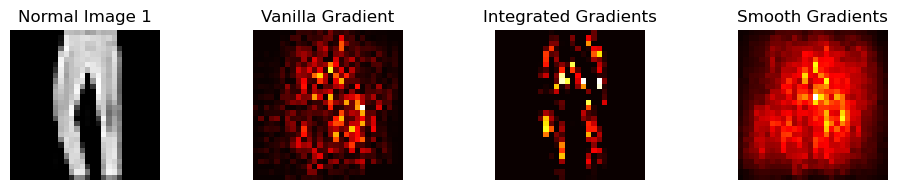

In [355]:
index = 5
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [357]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet_fmnist_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_adv = LeNet().to(device)
model_adv.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [359]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [361]:
a_batch_integrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = quantus.normalise_func.normalise_by_negative(Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model)
a_batch_smoothgrad = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())


In [363]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

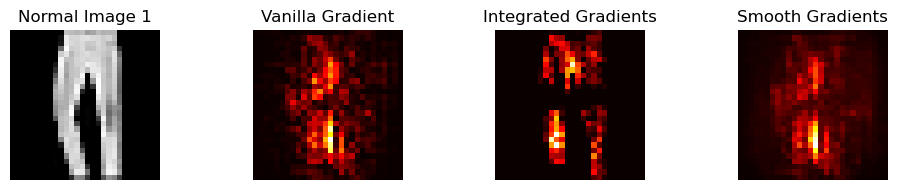

In [365]:

nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.reshape(x_batch[index], (28,28)), cmap="grey")
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_adv[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_adv[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_adv[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [186]:
def filter_and_compute_road(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain,
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    # Display the average values
    print("Average Values:")
    for key, value in average_values.items():
        print(f"{key}: {value}")


In [188]:
filter_and_compute_road(model, test_dataloader, device)

Average Values:
1: 0.980519321872469
6: 0.9523313680564047
11: 0.9345262657380812
16: 0.9155772287397922
21: 0.9018087767541272
26: 0.8817133836739284
31: 0.8651798880002097
36: 0.8435986630880592
41: 0.8208638235160595
46: 0.7907943138948048
51: 0.7653321267375014
56: 0.7212822591164385
61: 0.6797400635145824
66: 0.6270949583986123
71: 0.570208105190173
76: 0.497264256519688
81: 0.4187745856655383
86: 0.33851290371242493
91: 0.27495322197493094
96: 0.1570224477163883


In [190]:
filter_and_compute_road(model_adv, test_dataloader, device)

Average Values:
1: 0.9776635008856396
6: 0.9130937762358147
11: 0.8550316356322466
16: 0.7981008735647436
21: 0.743206465178651
26: 0.694771987016428
31: 0.6484913573909593
36: 0.6155145647685392
41: 0.5857218454951013
46: 0.5605913653521837
51: 0.5369455117128306
56: 0.5187157554427351
61: 0.4947555719283961
66: 0.47277711593333493
71: 0.4459212863521676
76: 0.4213985075777557
81: 0.3950917444281117
86: 0.34473729441458756
91: 0.2827938792526681
96: 0.1601857724990711


In [191]:
import math
def filter_and_compute_input_stability(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [192]:
print("The relative input stability score is: ", filter_and_compute_input_stability(model, test_dataloader, device))

The relative input stability score is:  4.916048670285232


In [193]:
print("The relative input stability score is: ", filter_and_compute_input_stability(model_adv, test_dataloader, device))

The relative input stability score is:  4.3626501457087


In [201]:
def filter_and_compute_output_stability(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [203]:
print("The relative output stability score is: ", filter_and_compute_output_stability(model, test_dataloader, device))

The relative output stability score is:  10.334893227947708


In [204]:
print("The relative output stability score is: ", filter_and_compute_output_stability(model_adv, test_dataloader, device))

The relative output stability score is:  10.672220787386726


In [205]:
def filter_and_compute_sparsity(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [206]:
print("The sparsity score is: ", filter_and_compute_sparsity(model, test_dataloader, device))

The sparsity score is:  (0.5677687426936806, 0.003827704201699615)


In [207]:
print("The sparsity score is: ", filter_and_compute_sparsity(model_adv, test_dataloader, device))

The sparsity score is:  (0.5874429138194804, 0.006468718623922003)
